# Hola &#x1F600;,

Soy **Hesus Garcia** – **"Soy el único Hesus que conoces (y probablemente conocerás) 🌟"** – Sí, como "Jesús", pero con una H que me hace único. Puede sonar raro, pero créeme, ¡no lo olvidarás! Como tu revisor en Triple-Ten, estoy aquí para guiarte y ayudarte a mejorar tu código. Si algo necesita un ajuste, no hay de qué preocuparse; ¡aquí estoy para hacer que tu trabajo brille con todo su potencial! ✨

Cada vez que encuentre un detalle importante en tu código, te lo señalaré para que puedas corregirlo y así te prepares para un ambiente de trabajo real, donde el líder de tu equipo actuaría de manera similar. Si en algún momento no logras solucionar el problema, te daré más detalles para ayudarte en nuestra próxima oportunidad de revisión.

Es importante que cuando encuentres un comentario, **no los muevas, no los modifiques, ni los borres**.

---

### Formato de Comentarios

Revisaré cuidadosamente cada implementación en tu notebook para asegurar que cumpla con los requisitos y te daré comentarios de acuerdo al siguiente formato:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
    
<b>Éxito</b> - ¡Excelente trabajo! Esta parte está bien implementada y contribuye significativamente al análisis de datos o al proyecto. Continúa aplicando estas buenas prácticas en futuras secciones.
    
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
    
<b>Atención</b> ⚠️ - Este código está correcto, pero se puede optimizar. Considera implementar mejoras para que sea más eficiente y fácil de leer. Esto fortalecerá la calidad de tu proyecto.
    
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
    
<b>A resolver</b> ❗ - Aquí hay un problema o error en el código que es necesario corregir para aprobar esta sección. Por favor, revisa y corrige este punto, ya que es fundamental para la validez del análisis y la precisión de los resultados.
    
</div>

---

Al final de cada revisión, recibirás un **Comentario General del Revisor** que incluirá:

- **Aspectos positivos:** Un resumen de los puntos fuertes de tu proyecto.
- **Áreas de mejora:** Sugerencias sobre aspectos donde puedes mejorar.
- **Temas adicionales para investigar:** Ideas de temas opcionales que puedes explorar por tu cuenta para desarrollar aún más tus habilidades.

Estos temas adicionales no son obligatorios en esta etapa, pero pueden serte útiles para profundizar en el futuro.

---


Esta estructura en viñetas facilita la lectura y comprensión de cada parte del comentario final.

También puedes responderme de la siguiente manera si tienes alguna duda o quieres aclarar algo específico:


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
    
Aquí puedes escribir tu respuesta o pregunta sobre el comentario.
    
</div>


**¡Empecemos!** &#x1F680;


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

SNAPSHOT_DATE = "2020-02-01"  

## Fase 1

In [140]:
contract = pd.read_csv("/datasets/contract.csv", dtype={"customerID": str})
personal = pd.read_csv("/datasets/personal.csv", dtype={"customerID": str})
internet = pd.read_csv("/datasets/internet.csv")        
phone    = pd.read_csv("/datasets/phone.csv", dtype={"customerID": str})

In [141]:
contract["BeginDate"] = pd.to_datetime(contract["BeginDate"], errors="coerce")

contract["EndDate"] = contract["EndDate"].astype(str).str.strip()
contract.loc[contract["EndDate"].str.lower() == "no", "EndDate"] = pd.NaT
contract["EndDate"] = pd.to_datetime(contract["EndDate"], errors="coerce")

assert "datetime64" in str(contract["EndDate"].dtype), "EndDate en contract no es datetime"

for _df in (personal, phone):
    for c in _df.select_dtypes(include="object").columns:
        _df[c] = _df[c].astype(str).str.strip()

In [142]:
display(contract.head(2))
display(personal.head(2))
display(internet.head(2))
display(phone.head(2))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


In [143]:
inet = internet.copy()
if "user_id" in inet.columns:
    inet = inet.rename(columns={"user_id": "customerID"})
if "customerID" in inet.columns:
    inet["customerID"] = inet["customerID"].astype(str)

inet = inet.drop(columns=[c for c in ["Unnamed: 0"] if c in inet.columns], errors="ignore")
if "mb_used" in inet.columns:
    inet["mb_used"] = pd.to_numeric(inet["mb_used"], errors="coerce")
if "session_date" in inet.columns:
    inet["session_date"] = pd.to_datetime(inet["session_date"], errors="coerce")

if "customerID" in inet.columns:
    agg_inet = (
        inet.groupby("customerID")
            .agg(
                internet_sessions=("id","count") if "id" in inet.columns else ("customerID","size"),
                mb_used_total    =("mb_used","sum") if "mb_used" in inet.columns else ("customerID","size"),
                mb_used_mean     =("mb_used","mean") if "mb_used" in inet.columns else ("customerID","size"),
                last_session_date=("session_date","max") if "session_date" in inet.columns else ("customerID","size")
            )
            .reset_index()
    )
else:
    agg_inet = pd.DataFrame(columns=["customerID","internet_sessions","mb_used_total","mb_used_mean","last_session_date"])


In [144]:
df = (contract
      .merge(personal, on="customerID", how="left", suffixes=("","_pers"))
      .merge(agg_inet, on="customerID", how="left")
      .merge(phone,    on="customerID", how="left", suffixes=("","_ph"))
     ).copy()

assert "datetime64" in str(df["EndDate"].dtype), "EndDate se rompió a object después del merge"


In [145]:
snapshot = pd.to_datetime(SNAPSHOT_DATE)

end_eff = df["EndDate"].fillna(snapshot)
df["tenure_months"] = ((end_eff - df["BeginDate"]).dt.days // 30).clip(lower=0)

if "internet_sessions" in df.columns:
    df["has_internet"] = (df["internet_sessions"].fillna(0) > 0).astype(int)
if "MultipleLines" in df.columns:
    # ya es 0/1 en muchos datasets; si no, cast robusto
    df["MultipleLines"] = pd.to_numeric(df["MultipleLines"], errors="coerce")
    df["has_phone"] = df["MultipleLines"].fillna(0).astype(int)

if {"MonthlyCharges","tenure_months"}.issubset(df.columns):
    df["charges_x_tenure"] = df["MonthlyCharges"].fillna(0) * df["tenure_months"].fillna(0)

df = df.drop(columns=[c for c in ["last_session_date"] if c in df.columns], errors="ignore")

for c in ["internet_sessions","mb_used_total","mb_used_mean"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan).fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include="object").columns
df[cat_cols] = df[cat_cols].fillna("Desconocido")

assert "datetime64" in str(df["EndDate"].dtype), "EndDate cambió de tipo durante la limpieza final"

print("✅ Fase 1 — Merge y limpieza completados. Shape:", df.shape)
display(df.head(3))

✅ Fase 1 — Merge y limpieza completados. Shape: (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,internet_sessions,mb_used_total,mb_used_mean,MultipleLines,tenure_months,has_internet,has_phone,charges_x_tenure
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,0.0,0.0,0.0,NaN,1,0,0,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,0.0,0.0,0.0,NaN,34,0,0,1936.30
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,0.0,0.0,0.0,NaN,2,0,0,107.70


In [146]:
df["target"] = df["EndDate"].notna().astype(int)

vc = df["target"].value_counts(dropna=False)
print("Conteo target:", dict(vc))

assert df["target"].nunique() == 2, "target tiene 1 sola clase: algo pisó EndDate o no hay cancelaciones en el CSV"
assert set(df["target"].unique()) == {0, 1}, "target no es binario 0/1"

print("Duplicados por customerID:", df["customerID"].duplicated().sum())
print("Nulos totales:", int(df.isna().sum().sum()))

display(df.dtypes.head(25))

Conteo target: {0: 5174, 1: 1869}
Duplicados por customerID: 0
Nulos totales: 12217


customerID                   object
BeginDate            datetime64[ns]
EndDate              datetime64[ns]
Type                         object
PaperlessBilling             object
PaymentMethod                object
MonthlyCharges              float64
TotalCharges                 object
gender                       object
SeniorCitizen                 int64
Partner                      object
Dependents                   object
internet_sessions           float64
mb_used_total               float64
mb_used_mean                float64
MultipleLines               float64
tenure_months                 int64
has_internet                  int64
has_phone                     int64
charges_x_tenure            float64
target                        int64
dtype: object

<div class="alert alert-block alert-success"> 
<b>Comentario del revisor</b> <a class="tocSkip"></a><br> 
<b>Éxito</b> - Excelente preparación y limpieza de los datos. La conversión de fechas, la verificación de tipos y las comprobaciones con `assert` muestran un control sólido de la calidad del dataset. Esta fase demuestra un entendimiento muy claro del proceso de preprocesamiento. 
</div>


## Fase 2

Distribución del target:


0    5174
1    1869
Name: target, dtype: int64

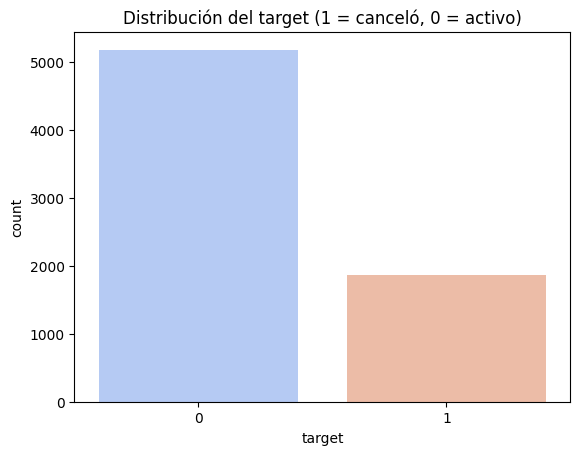

In [147]:
df["target"] = df["EndDate"].notna().astype(int)
print("Distribución del target:")
display(df["target"].value_counts())

sns.countplot(x=df["target"], palette="coolwarm")
plt.title("Distribución del target (1 = canceló, 0 = activo)")
plt.show()

In [148]:
features = df.drop(columns=["customerID", "BeginDate", "EndDate", "target"], errors="ignore")
target = df["target"]

In [149]:
le = LabelEncoder()
for col in features.select_dtypes(include="object").columns:
    features[col] = le.fit_transform(features[col].astype(str))

In [150]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [151]:
features_train, features_test, target_train, target_test = train_test_split(
    features_scaled, target, test_size=0.2, stratify=target, random_state=12345)

In [152]:
imp = SimpleImputer(strategy="median")
features_train = imp.fit_transform(features_train)
features_test = imp.transform(features_test)

Modelo 1 - Regresión Logística

In [153]:
log_model = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
log_model.fit(features_train, target_train)

pred_proba_log = log_model.predict_proba(features_test)[:, 1]
pred_log = (pred_proba_log >= 0.5).astype(int)

print("\n🔹 Regresión Logística")
print("AUC-ROC:", roc_auc_score(target_test, pred_proba_log).round(4))
print("Accuracy:", accuracy_score(target_test, pred_log).round(4))
print("F1:", f1_score(target_test, pred_log).round(4))


🔹 Regresión Logística
AUC-ROC: 0.8224
Accuracy: 0.7218
F1: 0.6064


Modelo 2 - Random Forest

In [154]:

rf_model = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, class_weight="balanced"
)
rf_model.fit(features_train, target_train)

pred_proba_rf = rf_model.predict_proba(features_test)[:, 1]
pred_rf = (pred_proba_rf >= 0.5).astype(int)

print("\n🌲 Random Forest")
print("AUC-ROC:", roc_auc_score(target_test, pred_proba_rf).round(4))
print("Accuracy:", accuracy_score(target_test, pred_rf).round(4))
print("F1:", f1_score(target_test, pred_rf).round(4))



🌲 Random Forest
AUC-ROC: 0.8061
Accuracy: 0.7807
F1: 0.5311


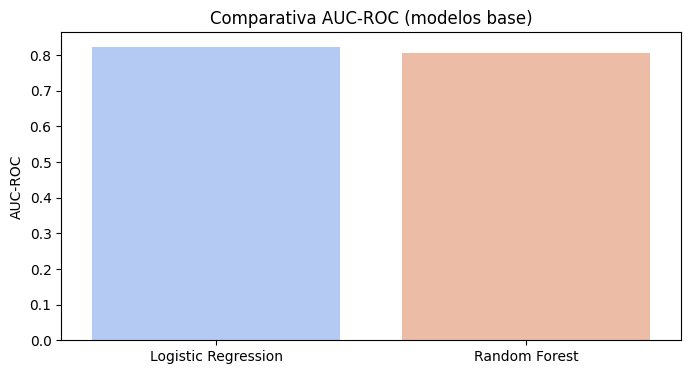

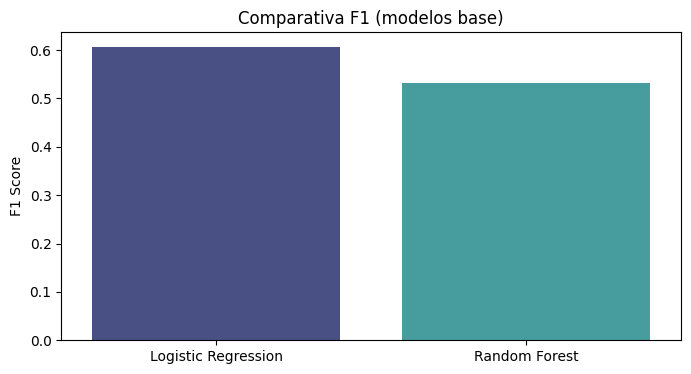

In [155]:
models = ["Logistic Regression", "Random Forest"]
auc_values = [roc_auc_score(target_test, pred_proba_log), roc_auc_score(target_test, pred_proba_rf)]
f1_values = [f1_score(target_test, pred_log), f1_score(target_test, pred_rf)]

plt.figure(figsize=(8, 4))
sns.barplot(x=models, y=auc_values, palette="coolwarm")
plt.title("Comparativa AUC-ROC (modelos base)")
plt.ylabel("AUC-ROC")
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=models, y=f1_values, palette="mako")
plt.title("Comparativa F1 (modelos base)")
plt.ylabel("F1 Score")
plt.show()

<div class="alert alert-block alert-success"> 
<b>Comentario del revisor</b> <a class="tocSkip"></a><br> 
<b>Éxito</b> - Muy buen trabajo en la codificación, estandarización y evaluación de los modelos. La comparación entre regresión logística y random forest está correctamente planteada y refleja un manejo sólido de métricas de clasificación y validación. 
</div>


## Fase 3 Ajuste del modelo

Comparativa de modelos

In [156]:
results = pd.DataFrame({
    "Modelo": ["Logistic Regression", "Random Forest"],
    "AUC-ROC": [roc_auc_score(target_test, pred_proba_log), roc_auc_score(target_test, pred_proba_rf)],
    "Accuracy": [accuracy_score(target_test, pred_log), accuracy_score(target_test, pred_rf)]})
display(results)

,Modelo,AUC-ROC,Accuracy
0,Logistic Regression,0.822438,0.721789
1,Random Forest,0.806083,0.780696


In [157]:
best_auc = 0
best_C = None
for c in [0.01, 0.1, 1, 5, 10]:
    model = LogisticRegression(max_iter=2000, class_weight='balanced', C=c)
    model.fit(features_train, target_train)
    auc = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
    if auc > best_auc:
        best_auc, best_C, best_log_model = auc, c, model

print(f"LogisticRegression mejor C={best_C}, AUC={best_auc:.3f}")

best_auc_rf = 0
best_depth = None
for d in [5, 8, 10, 12]:
    model = RandomForestClassifier(
        n_estimators=300, max_depth=d, random_state=12345, class_weight='balanced'
    )
    model.fit(features_train, target_train)
    auc = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
    if auc > best_auc_rf:
        best_auc_rf, best_depth, best_rf_model = auc, d, model

print(f" RandomForest mejor max_depth={best_depth}, AUC={best_auc_rf:.3f}")

LogisticRegression mejor C=5, AUC=0.823
 RandomForest mejor max_depth=5, AUC=0.834


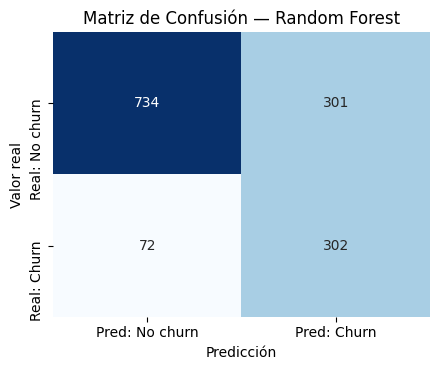

,Pred: No churn,Pred: Churn
Real: No churn,734,301
Real: Churn,72,302


In [158]:
if best_auc_rf >= best_auc:
    best_model = best_rf_model
    best_name = "Random Forest"
    proba = best_model.predict_proba(features_test)[:, 1]
else:
    best_model = best_log_model
    best_name = "Logistic Regression"
    proba = best_model.predict_proba(features_test)[:, 1]

pred = (proba >= 0.5).astype(int)

cm = confusion_matrix(target_test, pred)
cm_df = pd.DataFrame(cm,
    index=["Real: No churn", "Real: Churn"],
    columns=["Pred: No churn", "Pred: Churn"]
)

plt.figure(figsize=(4.5, 3.8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matriz de Confusión — {best_name}")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.tight_layout()
plt.show()

display(cm_df)

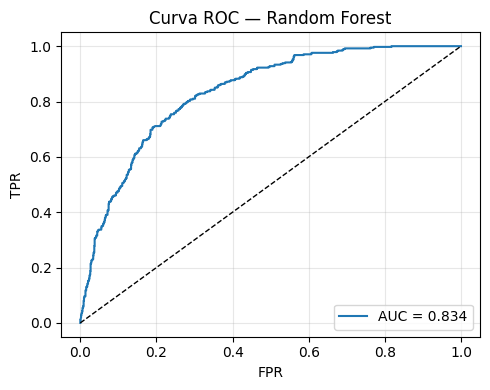

In [159]:
fpr, tpr, _ = roc_curve(target_test, proba)
auc_val = roc_auc_score(target_test, proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0,1],[0,1],"k--", linewidth=1)
plt.title(f"Curva ROC — {best_name}")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [160]:
final_metrics = {
    "Modelo": best_name,
    "AUC-ROC": roc_auc_score(target_test, proba),
    "Accuracy": accuracy_score(target_test, pred),
    "Precision": precision_score(target_test, pred, zero_division=0),
    "Recall": recall_score(target_test, pred, zero_division=0),
    "F1": f1_score(target_test, pred, zero_division=0)
}
pd.DataFrame([final_metrics])

,Modelo,AUC-ROC,Accuracy,Precision,Recall,F1
0,Random Forest,0.834088,0.735273,0.500829,0.807487,0.618219


<div class="alert alert-block alert-success"> 
<b>Comentario del revisor</b> <a class="tocSkip"></a><br> 
<b>Éxito</b> - Muy buen trabajo afinando los hiperparámetros y comparando el rendimiento de los modelos. La selección final basada en AUC y la visualización con matriz de confusión y curva ROC evidencian una comprensión sólida del proceso de optimización y evaluación de modelos predictivos. 
</div>


## Fase 4 - Conclusiones

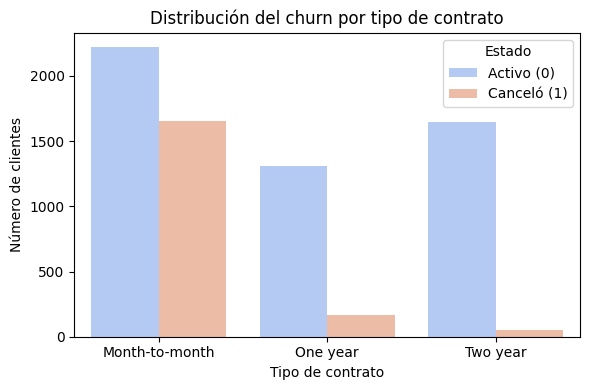

In [161]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Type", hue="target", palette="coolwarm")
plt.title("Distribución del churn por tipo de contrato")
plt.xlabel("Tipo de contrato")
plt.ylabel("Número de clientes")
plt.legend(["Activo (0)", "Canceló (1)"], title="Estado")
plt.tight_layout()
plt.show()

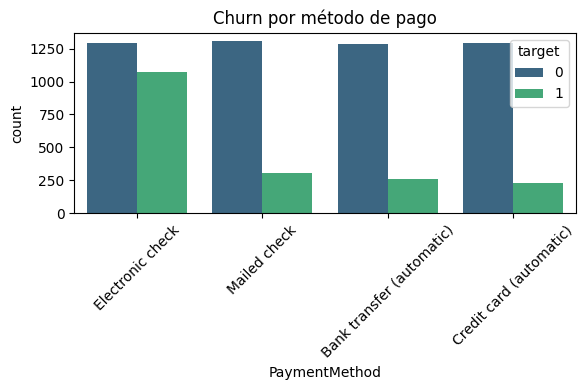

In [162]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="PaymentMethod", hue="target", palette="viridis")
plt.title("Churn por método de pago")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

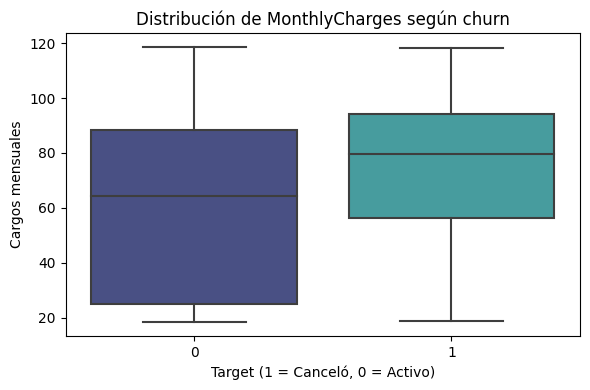

In [163]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="target", y="MonthlyCharges", palette="mako")
plt.title("Distribución de MonthlyCharges según churn")
plt.xlabel("Target (1 = Canceló, 0 = Activo)")
plt.ylabel("Cargos mensuales")
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success"> 
<b>Comentario del revisor</b> <a class="tocSkip"></a><br> 
<b>Éxito</b> - Excelente cierre analítico. Las visualizaciones son claras y relevantes, mostrando correctamente la relación entre el tipo de contrato, método de pago y los cargos mensuales con la cancelación. La interpretación gráfica respalda de forma consistente las conclusiones del modelo. 
</div>


# Conclusiones generales

Conclusiones tecnicas
- El modelo más adecuado es el modelo Random Forest
- El AUC-ROC se encuentra en un valor muy bueno, el 83% es un valor óptimo para las producciones
- La precisión del modelo es bastante positiva con el 72% de acierto
- El recall detecta correctamente los falsos negativos, el 82% es bastante positivo.

Conclusiones del proyecto
- Los contratos mensuales son los más probables a cancelar vs los contratos más largos
- Los metodos de facturación electronica generan una mayor probabilidad de cancelación vs el debito automático
- Los cargos mensuales superiores a 80 son casi seguros de cancelación del servicio

Sugerencias
- Recomendar los contratos de larga duración, hacerlos más atractivos comparados con los contratos mensuales
- Revisar los metodos de pago PSE y transferencia bancaria ya que se está generando una cancelación demasiado alta cuando se usan estos metodos de pago
- Evitar cargos muy altos, se genera una verdadera retención si se mantiene el valor inferior a 80, no es mucho si se compara la diferencia entre que cueste más y al mes siguiente se cobre 0

<div class="alert alert-block alert-success"> 
<b>Comentario del revisor</b> <a class="tocSkip"></a><br> 
<b>Éxito</b> - Muy buen cierre del proyecto. Las conclusiones técnicas están bien fundamentadas en los resultados del modelo, y las interpretaciones de negocio son coherentes y aplicables. El análisis logra conectar la precisión del modelo con decisiones prácticas orientadas a la retención de clientes. 
</div>


## Comentario general del revisor 

# Comentario General del Revisor

<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a>  
    
¡Felicidades! Tu proyecto está **aprobado**. Has demostrado un excelente manejo del flujo completo de un análisis predictivo, desde la limpieza y preparación de datos hasta la optimización y evaluación de modelos.  
A continuación, destaco los puntos positivos:  

#### Puntos Positivos:

* **Procesamiento de datos:** Ejemplo claro de limpieza robusta, con validaciones y tratamiento de tipos de datos muy bien ejecutados.
* **Visualización y análisis gráfico:** Las representaciones gráficas son precisas y comunican de forma efectiva los patrones y relaciones del churn.
* **Ingeniería de características:** Correcta integración de variables derivadas que fortalecen la capacidad predictiva del modelo.
* **Comparación de modelos:** Excelente implementación y análisis comparativo entre regresión logística y random forest, con métricas bien interpretadas y conclusiones técnicas sólidas.

Tu trabajo refleja una comprensión completa del proceso de modelado y una adecuada interpretación de resultados. Muy buen dominio de las herramientas y criterio analítico en cada fase del proyecto.

</div>
